In [10]:
pip install -r ../requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: /usr/local/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [12]:
plt.style.use('default')
sns.set_palette('husl')  # Use colorblind-friendly colors
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [13]:
def explore_dataset(features_df, patient_notes_df, train_df):
    """Explore the NBME dataset structure"""
    print("=" * 80)
    print("DATASET OVERVIEW")
    print("=" * 80)

    print("\n📊 Features Dataset:")
    print(f"Shape: {features_df.shape}")
    print(f"Columns: {features_df.columns.tolist()}")
    print(features_df.head())

    print("\n📝 Patient Notes Dataset:")
    print(f"Shape: {patient_notes_df.shape}")
    print(f"Columns: {patient_notes_df.columns.tolist()}")
    print(patient_notes_df.head())

    print("\n🎯 Training Dataset:")
    print(f"Shape: {train_df.shape}")
    print(f"Columns: {train_df.columns.tolist()}")
    print(train_df.head())

    # Sample note
    if 'pn_history' in patient_notes_df.columns:
        print("\n📄 Sample Patient Note:")
        print("-" * 80)
        sample_note = patient_notes_df['pn_history'].iloc[0]
        print(sample_note[:500] + "..." if len(sample_note) > 500 else sample_note)
        print("-" * 80)

    return features_df, patient_notes_df, train_df


In [14]:
# =============================================================================
# STEP 2: TEXT PREPROCESSING
# =============================================================================

class NotePreprocessor:
    """Preprocess and clean clinical notes"""

    def __init__(self):
        self.common_medical_abbrev = {
            'pt': 'patient',
            'hx': 'history',
            'dx': 'diagnosis',
            'tx': 'treatment',
            'sx': 'symptoms',
            'y/o': 'year old',
            'yo': 'year old',
            'c/o': 'complains of',
            'w/': 'with',
            'w/o': 'without',
            's/p': 'status post',
            'h/o': 'history of',
        }

    def clean_text(self, text):
        """Basic text cleaning"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Expand common abbreviations
        for abbrev, full in self.common_medical_abbrev.items():
            text = re.sub(r'\b' + abbrev + r'\b', full, text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def extract_sentences(self, text):
        """Split text into sentences"""
        # Simple sentence splitting (can be improved with nltk)
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        return sentences

    def categorize_sentence(self, sentence):
        """Categorize sentence into clinical sections"""
        sentence_lower = sentence.lower()

        # Define keyword patterns for each section
        categories = {
            'chief_complaint': ['complains', 'presents', 'chief complaint', 'c/c', 'complaining'],
            'history': ['history', 'past', 'previous', 'ago', 'since', 'started'],
            'symptoms': ['pain', 'fever', 'cough', 'nausea', 'vomiting', 'headache', 'fatigue'],
            'medications': ['taking', 'medication', 'prescribed', 'drug', 'aspirin', 'ibuprofen'],
            'physical_exam': ['exam', 'examination', 'auscultation', 'palpation', 'vital signs'],
            'assessment': ['diagnosis', 'likely', 'impression', 'assessment', 'appears'],
            'plan': ['plan', 'recommend', 'prescribe', 'follow up', 'referral']
        }

        # Score each category
        scores = {}
        for category, keywords in categories.items():
            score = sum(1 for keyword in keywords if keyword in sentence_lower)
            if score > 0:
                scores[category] = score

        # Return highest scoring category or 'other'
        if scores:
            return max(scores, key=scores.get)
        return 'other'



In [15]:
# =============================================================================
# STEP 3: STRUCTURED SUMMARY GENERATOR
# =============================================================================

class MedicalNoteSummarizer:
    """Generate structured summaries from clinical notes"""

    def __init__(self):
        self.preprocessor = NotePreprocessor()
        self.sections = {
            'chief_complaint': [],
            'history': [],
            'symptoms': [],
            'medications': [],
            'physical_exam': [],
            'assessment': [],
            'plan': [],
            'other': []
        }

    def reset(self):
        """Reset sections for new note"""
        for key in self.sections:
            self.sections[key] = []

    def process_note(self, note_text):
        """Process a single clinical note"""
        self.reset()

        # Clean and extract sentences
        cleaned_text = self.preprocessor.clean_text(note_text)
        sentences = self.preprocessor.extract_sentences(cleaned_text)

        # Categorize each sentence
        for sentence in sentences:
            category = self.preprocessor.categorize_sentence(sentence)
            self.sections[category].append(sentence)

        return self.sections

    def generate_summary(self, note_text):
        """Generate a structured summary"""
        sections = self.process_note(note_text)

        summary = []
        summary.append("=" * 60)
        summary.append("PATIENT NOTE SUMMARY")
        summary.append("=" * 60)

        # Define section order and display names
        section_order = [
            ('chief_complaint', 'CHIEF COMPLAINT'),
            ('history', 'HISTORY'),
            ('symptoms', 'SYMPTOMS'),
            ('physical_exam', 'PHYSICAL EXAMINATION'),
            ('assessment', 'ASSESSMENT'),
            ('plan', 'PLAN'),
            ('medications', 'MEDICATIONS'),
        ]

        for section_key, section_name in section_order:
            if sections[section_key]:
                summary.append(f"\n{section_name}:")
                summary.append("-" * 60)
                for item in sections[section_key]:
                    summary.append(f"  • {item.capitalize()}")

        return "\n".join(summary)

    def extract_key_entities(self, note_text):
        """Extract key medical entities (simplified version)"""
        cleaned = self.preprocessor.clean_text(note_text)

        entities = {
            'symptoms': [],
            'medications': [],
            'conditions': []
        }

        # Common symptoms
        symptom_keywords = ['pain', 'fever', 'cough', 'nausea', 'vomiting',
                           'headache', 'fatigue', 'weakness', 'dizzy']

        # Common medications
        med_keywords = ['aspirin', 'ibuprofen', 'tylenol', 'antibiotic',
                       'medication', 'drug', 'prescribed']

        words = cleaned.split()
        for i, word in enumerate(words):
            if word in symptom_keywords:
                context = ' '.join(words[max(0,i-2):min(len(words),i+3)])
                entities['symptoms'].append(context)
            elif word in med_keywords:
                context = ' '.join(words[max(0,i-2):min(len(words),i+3)])
                entities['medications'].append(context)

        return entities

In [16]:
# =============================================================================
# STEP 4: VISUALIZATION & ANALYSIS
# =============================================================================

def visualize_note_analysis(patient_notes_df, summarizer):
    """Visualize note characteristics"""

    # Analyze all notes
    note_lengths = []
    section_counts = {section: [] for section in summarizer.sections.keys()}

    for note in patient_notes_df['pn_history'][:100]:  # Sample first 100
        if pd.notna(note):
            note_lengths.append(len(note))
            sections = summarizer.process_note(note)
            for section, content in sections.items():
                section_counts[section].append(len(content))

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Note length distribution
    axes[0, 0].hist(note_lengths, bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Note Lengths', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Characters')
    axes[0, 0].set_ylabel('Frequency')

    # 2. Section distribution
    avg_sections = {k: np.mean(v) if v else 0 for k, v in section_counts.items()}
    sections = list(avg_sections.keys())
    counts = list(avg_sections.values())

    axes[0, 1].barh(sections, counts, color='coral')
    axes[0, 1].set_title('Average Sentences per Section', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Average Count')

    # 3. Most common sections
    section_presence = {k: sum(1 for x in v if x > 0) for k, v in section_counts.items()}
    sections_sorted = sorted(section_presence.items(), key=lambda x: x[1], reverse=True)

    axes[1, 0].bar([x[0] for x in sections_sorted], [x[1] for x in sections_sorted],
                   color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Section Frequency in Notes', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Notes')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Summary statistics
    axes[1, 1].axis('off')
    stats_text = f"""
    SUMMARY STATISTICS
    ==================
    Total Notes Analyzed: {len(note_lengths)}

    Average Note Length: {np.mean(note_lengths):.0f} chars
    Median Note Length: {np.median(note_lengths):.0f} chars

    Most Common Section: {sections_sorted[0][0]}
    Least Common Section: {sections_sorted[-1][0]}

    Avg Sections per Note: {np.mean([sum(1 for x in counts if x > 0) for counts in zip(*section_counts.values())]):.1f}
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center')

    plt.tight_layout()
    plt.show()


🏥 NBME CLINICAL NOTE SUMMARIZER

📊 STEP 1: EXPLORING DATASET...
DATASET OVERVIEW

📊 Features Dataset:
Shape: (143, 3)
Columns: ['feature_num', 'case_num', 'feature_text']
   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
2            2         0                                     Chest-pressure
3            3         0                              Intermittent-symptoms
4            4         0                                        Lightheaded

📝 Patient Notes Dataset:
Shape: (42146, 3)
Columns: ['pn_num', 'case_num', 'pn_history']
   pn_num  case_num                                         pn_history
0       0         0  17-year-old male, has come to the student heal...
1       1         0  17 yo male with recurrent palpitations for the...
2       2         0  Dillon Cleveland is a 17 y.o. male patient wit...

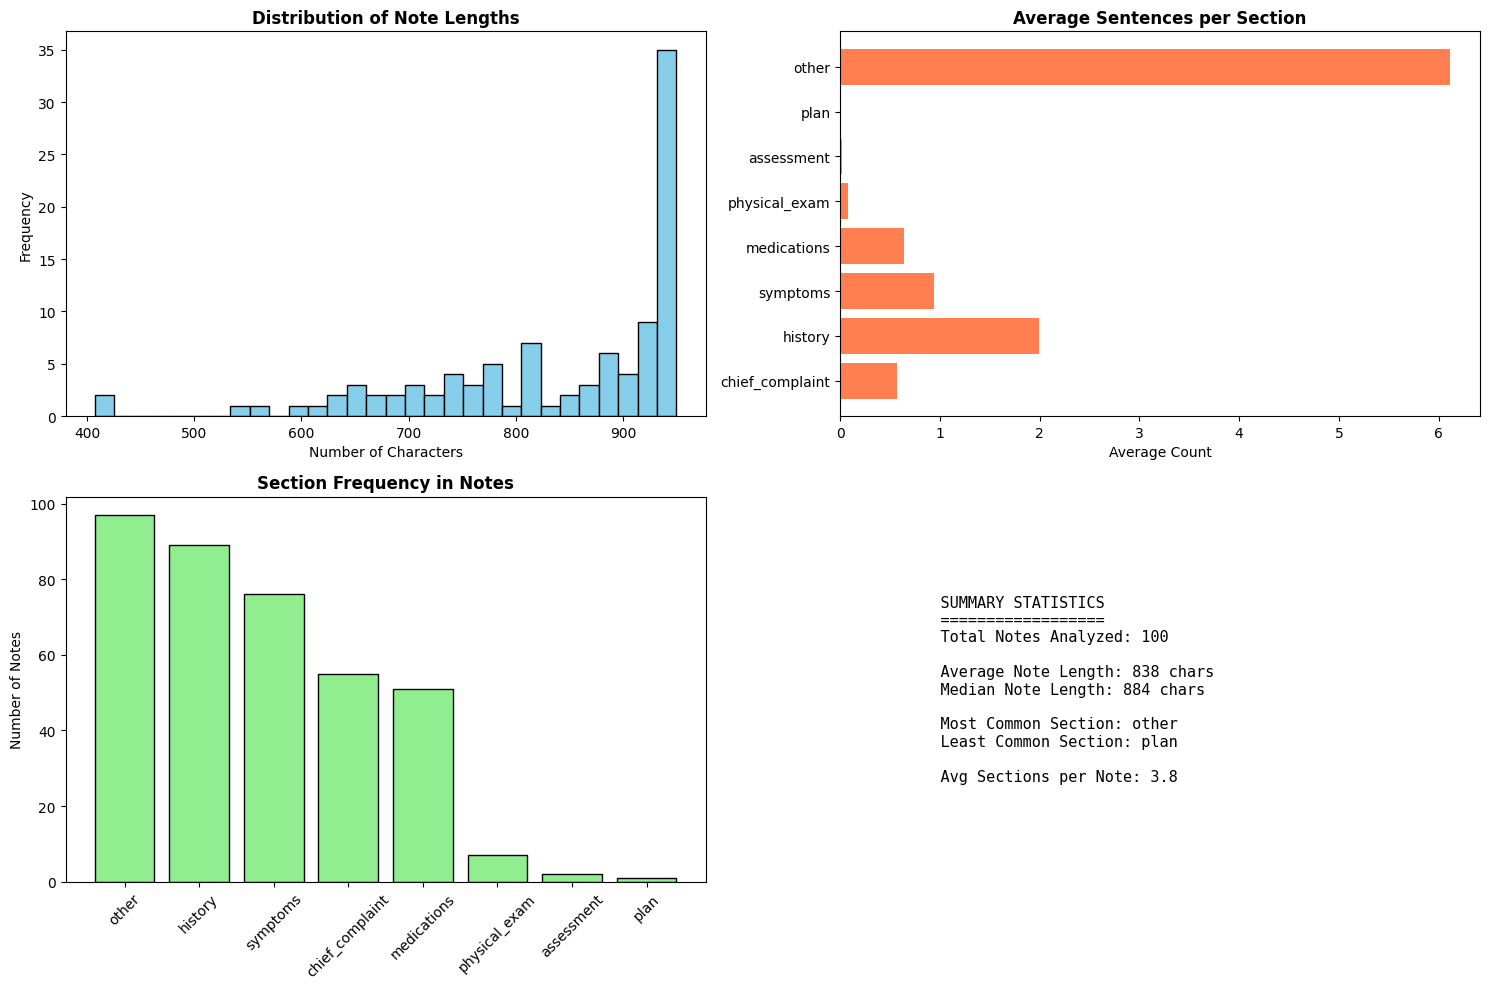


✅ PIPELINE COMPLETE!

Next Steps:
1. Improve text categorization with ML models
2. Add named entity recognition (NER) for medical terms
3. Implement extractive/abstractive summarization
4. Create patient-friendly language conversion


In [18]:
# =============================================================================
# STEP 5: MAIN EXECUTION
# =============================================================================

def main():
    """Main execution pipeline"""

    print("🏥 NBME CLINICAL NOTE SUMMARIZER")
    print("=" * 80)

    # Load data (update paths as needed)
    features_df = pd.read_csv('../data/raw/nbme-score-clinical-patient-notes/features.csv')
    patient_notes_df = pd.read_csv('../data/raw/nbme-score-clinical-patient-notes/patient_notes.csv')
    train_df = pd.read_csv('../data/raw/nbme-score-clinical-patient-notes/train.csv')

    # Step 1: Explore
    print("\n📊 STEP 1: EXPLORING DATASET...")
    explore_dataset(features_df, patient_notes_df, train_df)

    # Step 2: Initialize summarizer
    print("\n🔧 STEP 2: INITIALIZING SUMMARIZER...")
    summarizer = MedicalNoteSummarizer()

    # Step 3: Process sample notes
    print("\n📝 STEP 3: PROCESSING SAMPLE NOTES...")
    sample_note = patient_notes_df['pn_history'].iloc[0]

    print("\n" + "=" * 80)
    print("ORIGINAL NOTE (First 500 chars):")
    print("=" * 80)
    print(sample_note[:500] + "...")

    print("\n" + "=" * 80)
    print("STRUCTURED SUMMARY:")
    print("=" * 80)
    summary = summarizer.generate_summary(sample_note)
    print(summary)

    # Step 4: Extract entities
    print("\n" + "=" * 80)
    print("KEY ENTITIES EXTRACTED:")
    print("=" * 80)
    entities = summarizer.extract_key_entities(sample_note)
    for entity_type, items in entities.items():
        if items:
            print(f"\n{entity_type.upper()}:")
            for item in items[:5]:  # Show first 5
                print(f"  • {item}")

    # Step 5: Visualize
    print("\n📊 STEP 4: GENERATING VISUALIZATIONS...")
    visualize_note_analysis(patient_notes_df, summarizer)

    print("\n✅ PIPELINE COMPLETE!")
    print("\nNext Steps:")
    print("1. Improve text categorization with ML models")
    print("2. Add named entity recognition (NER) for medical terms")
    print("3. Implement extractive/abstractive summarization")
    print("4. Create patient-friendly language conversion")

    return summarizer, features_df, patient_notes_df, train_df


# Run the pipeline
if __name__ == "__main__":
    summarizer, features_df, patient_notes_df, train_df = main()